# Heisen (2023) - Efficient Parallelization of a Ubiquitous Sequential Computation

In [1]:
!which python

/Users/tristantorchet/Desktop/Code/VSCode/LearningJAX/.venv/bin/python


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

jnp.set_printoptions(precision=2)

## 1. simple cumsum

$
\text{Given } x_0 \text{, } a = [a_1, a_2, ..., a_n] \text{, } b = [b_1, b_2, ..., b_n] \\
x_{i+1} = a_i * x_i + b_i \\
$

In [3]:
seq_len = 1000
key = jax.random.PRNGKey(0)
key, subkey_a = jax.random.split(key)
a = jax.random.normal(subkey_a, (seq_len,))

### 1.1 Using a for loop to compute the correct cumsum which will be used to verify the correctness of the parallelized version

In [4]:
gt_result = []
x_t = 0 
for i in range(seq_len):
    x_t += a[i]
    gt_result.append(x_t)
gt_result = jnp.array(gt_result)
print(gt_result.shape)
print(gt_result[:5])

(1000,)
[ 1.24  0.08 -1.94 -2.46 -2.71]


### 1.2 Comparing the speed of manual, jit_manual, lax.scan, and jnp.cumsum

In [5]:
def cumsum_manual(a):
    x_t = 0
    x_cs = []
    for i in range(seq_len):
        x_t += a[i]
        x_cs.append(x_t)
    return jnp.array(x_cs)

jit_cumsum_manual = jax.jit(cumsum_manual)

def cumsum_lax_scan(state, a):
    x_t = state
    x_t += a
    return x_t, x_t # state and output

x_0 = 0.
_, result_lax_scan = jax.lax.scan(cumsum_lax_scan, x_0, a)
result_jit = jit_cumsum_manual(a) # warm up
result_jnpcs = jnp.cumsum(a) # warm up
result_lax_ass_scan = jax.lax.associative_scan(jnp.add, a) # warm up

print('Lax scan correct:')
print(jnp.allclose(result_lax_scan, gt_result, atol=1e-6))
print('Jit correct:')
print(jnp.allclose(result_jit, gt_result, atol=1e-6))
print('Jnp cumsum correct:')
print(jnp.allclose(result_jnpcs, gt_result, atol=1e-4)) # need a higher atol
print('lax associative scan correct:')
print(jnp.allclose(result_lax_ass_scan, gt_result, atol=1e-4)) # need a higher atol



print('\nmanual')
%timeit -n 1 -r 7 cumsum_manual(a)
print('\njit manual')
%timeit -n 1 -r 7 jit_cumsum_manual(a)
print('\nlax scan')
%timeit -n 1 -r 7 jax.lax.scan(cumsum_lax_scan, x_0, a)
print('\ncumsum jnp')
%timeit -n 1 -r 7 jnp.cumsum(a)
print('\nlax ass scan')
%timeit -n 1 -r 7 jax.lax.associative_scan(jnp.add, a)

Lax scan correct:
True
Jit correct:
True
Jnp cumsum correct:
True
lax associative scan correct:
True

manual
105 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

jit manual
The slowest run took 16.97 times longer than the fastest. This could mean that an intermediate result is being cached.
38 μs ± 59.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

lax scan
125 μs ± 54.2 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

cumsum jnp
12.5 μs ± 6.76 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

lax ass scan
1.39 ms ± 300 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Affine cumsum

In [6]:
seq_len = 1000
key = jax.random.PRNGKey(0)
key, subkey_a, subkey_b = jax.random.split(key, 3)
a = jax.random.normal(subkey_a, (seq_len,))
b = jax.random.normal(subkey_b, (seq_len,))
print(a[:5])

[-9.97e-01 -9.73e-04 -4.83e-01 -1.57e+00 -6.24e-01]


### 2.1 Using a for loop to compute the correct affine cumsum which will be used to verify the correctness of the parallelized version

In [7]:
gt_aff_cs_res = []
x_t = 0
gt_aff_cs_res.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b[i]
    gt_aff_cs_res.append(x_t)
gt_aff_cs_res = jnp.array(gt_aff_cs_res)

In [8]:
def affine_cumsum_manual(a, b):
    x_cs = []
    x_t = 0
    x_cs.append(x_t)
    for i in range(seq_len):
        x_t = a[i] * x_t + b[i]
        x_cs.append(x_t)
    return jnp.array(x_cs)

result_aff_cs_man = affine_cumsum_manual(a, b)
print(jnp.allclose(gt_aff_cs_res, result_aff_cs_man, atol=1e-6))

%timeit -n 1 -r 7 affine_cumsum_manual(a, b)

True
149 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
_ = jit_affine_cumsum_manual(a, b) # this takes a while ~ 16s

# warm up
_ = jit_affine_cumsum_manual(a, b) # this takes a while ~ 16s
%timeit -n 1 -r 7 jit_affine_cumsum_manual(a, b)

NameError: name 'jit_affine_cumsum_manual' is not defined

## 3 Recursion using cumsum

$
\text{Given } x_0 \text{, } a = [a_1, a_2, ..., a_n] \text{, } b = [b_1, b_2, ..., b_n] \\
x_{i+1} = a_i * x_i + b_i \\
x_{i+1} = a_i * (a_{i-1} * x_{i-1} + b_{i-1}) + b_i \\
x_{i+1} = a_i * (a_{i-1} * (a_{i-2} * x_{i-2} + b_{i-2}) + b_{i-1}) + b_i \\
x_{i+1} = ... \text{ and so on} \\
x_{i+1} = a_i * a_{i-1} * a_{i-2} * x_{i-2} + a_i * a_{i-1} * b_{i-2} + a_i * b_{i-1} + b_i \\
x_{i+1} = (\prod_{j=1}^{i} a_j)*(x_0 + b_{i-2}/a_{i-2} + b_{i-1}/(a_{i-1} * a_{i-2}) + b_i) \\
x_{i+1} = (a_i * a_{i-1} * ... * a_1) * x_0 + (a_i * a_{i-1} * ... * a_2) * b_1 + ... + a_i * b_{i-1} + b_i \\
\text{until now } x_{i+1} \text{ is a scalar} \\
\text{vectorizing the above equation} \\
\overrightarrow{x}_t = cumprod(a[:i+1]) ( x_0 + cumsum( b[:i+1] / a[:i+1]) ) \text{ where a[:i+1] and b[:i+1] are arrays} \\
\overrightarrow{x}_t = [x_0, x_0+x_1, x_0+x_1+x_2, ..., x_0+x_1+...+x_{t-1}] \\
$

<font color='red'>**WARNING**</font>: The second line is correct, and I think the paper's equation is wrongly written because of the shape.</font>
Let me explain, the paper's equation make sense for computer function: 

<font color='green'>**python**</font>
```python
a_cumprod = jnp.cumprod(a,)
c = jnp.cumsum(b / a_cumprod) # makes sense because b and a_cumprod are vectors of same shape
```
<font color='green'>**end python**</font>

The formula is: $ \overrightarrow{x}_t = (\prod_{t}^{cum} a_t) \odot (x_0 + \sum_{t}^{cum} \frac{b_t}{\prod_{t}^{cum} a_t}) $
$b_t$ is a scalar while $\prod_{t}^{cum} a_t$ is a vector.

In makes more sense to write: $ \overrightarrow{x}_t = (\prod_{n=1}^{t,cum} a_n) \odot (x_0 + \sum_{n=1}^{t,cum} \frac{b_n}{\prod_{n=1}^{t} a_n}) $

Where we have:
- adjusted the index of the sum and product to explicitly show that we are summing and multiplying from 1 to t
- we do not cumulate the product of a in the denominator of the sum
---

<font color='orange'>**WARNING**</font>: We need to ensure that $a$ and $b$ are <font color='orange'>**positive**</font> because the acceleration uses logaritmic scale.

In [45]:
seq_len = 1000
key = jax.random.PRNGKey(0)
key, subkey_a, subkey_b = jax.random.split(key, 3)
# a = jax.random.normal(subkey_a, (seq_len,))
# uniform a from 0.1 to 1
a = jax.random.uniform(subkey_a, (seq_len,), minval=0.1, maxval=1)
 
#a = jnp.abs(a) # make sure it is positive, because we will use log
b = jax.random.normal(subkey_b, (seq_len,))
b_scaled = b + 4
#b = jnp.abs(b) # make sure it is positive, because we will use log
print(a[:5])

[0.24 0.55 0.38 0.15 0.34]


In [60]:
gt_aff_cs_res = []
x_t = 1
gt_aff_cs_res.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b[i]
    gt_aff_cs_res.append(x_t)
gt_aff_cs_res = jnp.array(gt_aff_cs_res)

gt_aff_cs_res_scaled = []
x_t = 1
gt_aff_cs_res_scaled.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b_scaled[i]
    gt_aff_cs_res_scaled.append(x_t)
gt_aff_cs_res_scaled = jnp.array(gt_aff_cs_res_scaled)

gt_aff_cs_res_corrected = []
x_t = 1

gt_aff_cs_res_corrected.append(x_t)
for i in range(seq_len):
    tmp = 1
    for j in range(i): 
        prod = 1
        for k in range(j, i):
            prod *= a[k]
        tmp += 1/prod
    
    x_t = a[i] * x_t + b_scaled[i] - 4 * tmp
    if x_t < 0:
        x_t = 0
    gt_aff_cs_res_corrected.append(x_t)

KeyboardInterrupt: 

In [63]:
log_a = jnp.log(a)
a_star = jnp.cumsum(log_a)
c = jnp.exp(-a_star) * b
print(c.shape)
print(a_star)
print(c[-5:])

(1000,)
[-inf -inf -inf -inf -inf]


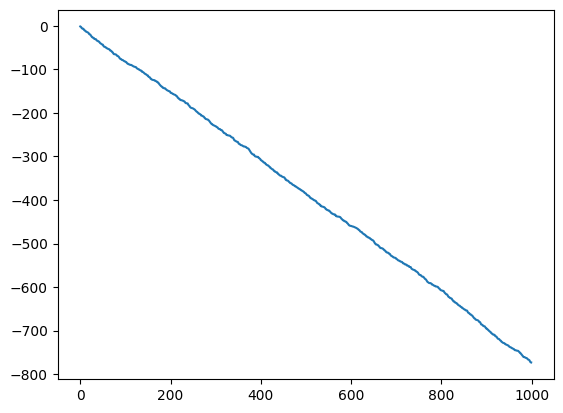

In [71]:
plt.plot(a_star)


NameError: name 'gt_aff_cs_res_corrected' is not defined

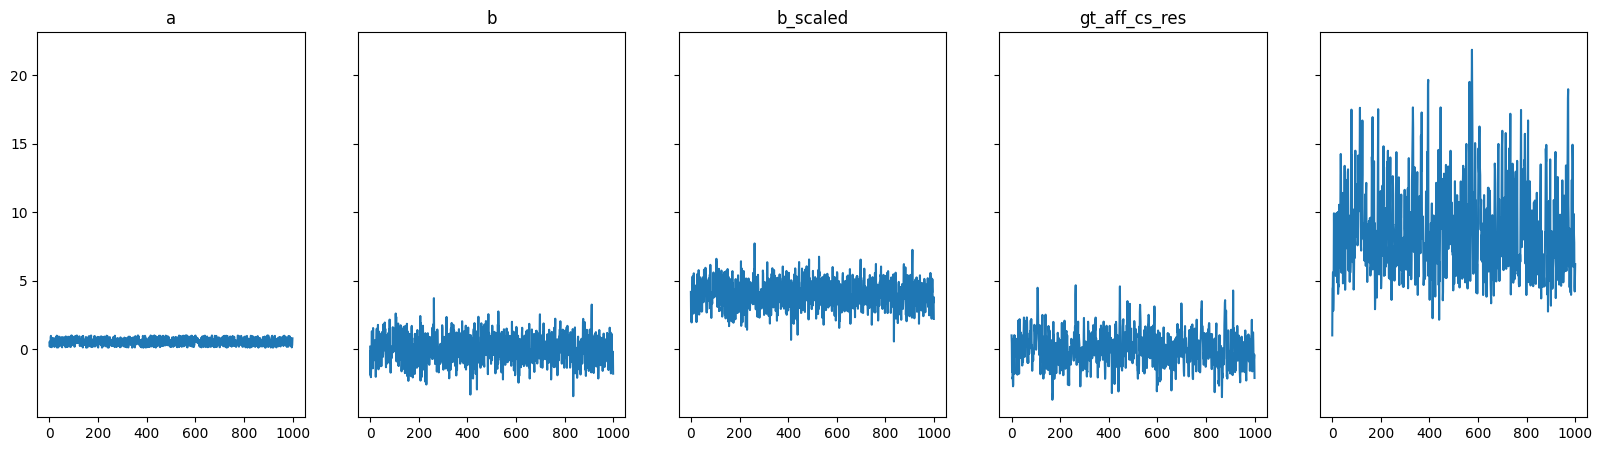

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
ax[0].plot(a)
ax[0].set_title('a')
ax[1].plot(b)
ax[1].set_title('b')
ax[2].plot(b_scaled)
ax[2].set_title('b_scaled')
ax[3].plot(gt_aff_cs_res)
ax[3].set_title('gt_aff_cs_res')
ax[4].plot(gt_aff_cs_res_scaled)
ax[4].plot(gt_aff_cs_res_corrected)
# ax[4].plot(gt_aff_cs_res_scaled * jnp.log(4))
ax[4].set_title('gt_aff_cs_res_scaled')

plt.show()

### 3.1 Using Heinsen vanilla formulation (unstable if the cumulative prodct goes to zero)
$
\vec{x}_t = \prod_{n=1}^{t} a_n \odot (x_0 + \sum_{n=1}^{t} \frac{b_n}{\prod_{n=1}^{t} a_n}) \\
$
Two problems:
- If any of the $a_n$ is zero, the product will be zero and the division will be undefined.
- If multiple of the $a_n$ are close to zero, the product will be zero and the division will be undefined.

In [ ]:
@jax.jit
def cumprod(a):
    x_t = 1.
    res = []
    for _, a in enumerate(a):
        x_t *= a 
        res.append(x_t)
    return jnp.array(res)

a_cp = cumprod(a)

# check if a_cp has a 0
if jnp.any(a_cp == 0):
    print('a_cp has a 0')
    for i in range(seq_len):
        if a_cp[i] == 0:
            
            break
    print(zeros)

a_cp has a 0:
True
[132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 

A solution would be to pass the $a$ into a shifted and compressed saturating function --> <font color='red'>**NO**</font>

We can use the sigmoid function: 
$
y = \alpha * \sigma(\gamma * (a-\delta) ) + \beta \\
$
- $\alpha$ is the amplitude, $\beta$ is the vertical shift, $\gamma$ is the slope, and $\delta$ is the horizontal shift.
- With $\alpha = 1.0$, $\beta = 0.0$, $\gamma = 1$, and $\delta = 0$, the sigmoid function will range from 0 to 1.0.
- With $\alpha = 0.6$, $\beta = 0.2$, $\gamma = 7$, and $\delta = -0.5$, the sigmoid function will range from 0.2 to 0.8, will be centered at a=0.5 --> approximates the linear function. on the range of 0.2 to 0.8.

We could use the tanh function:
$
y = \alpha * (\tanh(\gamma * a ) + \beta) \\
$

- $\alpha < 1.0$ is the compression, 
- $\beta = 1.0$ is the shift,
- $\gamma = 10.0$ is the slope.
- With $alpha=1$, $beta=0$, and $\gamma=1$, the tanh ranges from -1 to 1 (amplitude 2).


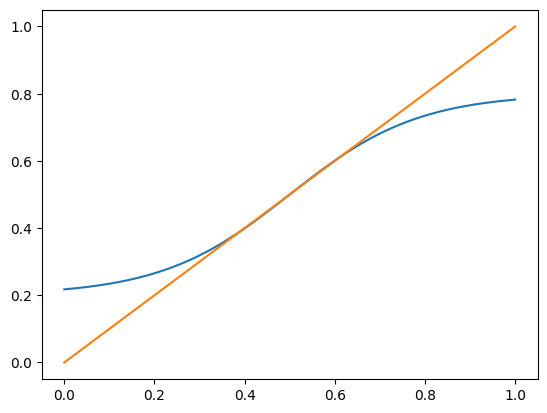

In [13]:
def modified_sigmoid(x, alpha: float = 0.6, beta: float = 0.2, gamma: float = 7.0, delta: float = -0.5):
    return alpha * (1. / (1. + jnp.exp(-gamma * (x + delta)))) + beta

x = jnp.linspace(0, 1, 1000)
y = modified_sigmoid(x)

plt.plot(x, y)
plt.plot(x,x)

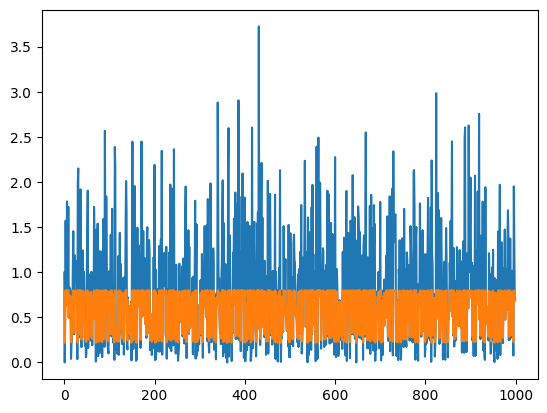

In [15]:
plt.plot(a)
plt.plot(modified_sigmoid(a))

In [ ]:


@jax.jit
def modified_cumprod(a):
    a_ = modified_sigmoid(a)
    x_t = 1.
    res = []
    for _, a_i in enumerate(a_):
        x_t *= a_i 
        res.append(x_t)
    return jnp.array(res)

a_modified_cp = modified_cumprod(a)


zeros = []
for i in range(seq_len):
    if a_modified_cp[i] == 0:
        zeros.append(i)
    if len(zeros) > 10:
        break

print(zeros)

# check if a_cp has a 0
print('a_modified_cp has a 0:')
print(jnp.any(a_modified_cp == 0))

In [ ]:
@jax.jit
def cumsum_div(x, y):
    return jnp.cumsum(x/y)

c = cumsum_div(b, a_cp)
print(c[:5])

As the cumulative product of $a$ is used in the denominator, the recursion is unstable if the cumulative product goes to zero.

In [33]:
# check if a_cp has a 0
print(jnp.any(a_cp == 0))

True


Indeed, running the following cells, we will see that the $final$ sequences has `nan` values.

In [34]:
# d = inputs[0] + c 
d = 1 + c 
final = a_cp * d
print(final[:5])
print(gt_aff_cs_res[1:6])

[1.1750548 1.9014025 1.0463172 3.697421  3.5984402]
[1.1750548 1.9014025 1.0463173 3.697421  3.5984402]


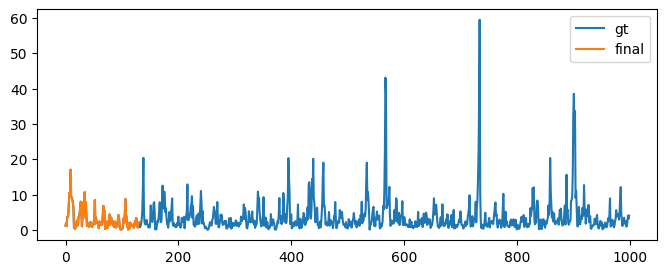

In [35]:
# plot 
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
gt_to_plot = gt_aff_cs_res[1:]
final_to_plot = final
fig, ax = plt.subplots(1,1, figsize=(800*px, 300*px))
t = np.arange(seq_len)
ax.plot(t, gt_to_plot, label='gt')
ax.plot(t, final_to_plot, label='final')
ax.legend()
plt.show()


### 3.2 Using Heinsen stable formulation using log

### 3.2.1 Stable jax.lax.cumlogsumexp

In [72]:
log_a = jnp.log(a)
a_star = jnp.cumsum(log_a)

log_b = jnp.log(b)
c = log_b - a_star 
c_star = jnp.zeros((c.shape[0]+ 1, ))
c_star = c_star.at[1:].set(c)
c_star = c_star.at[0].set(0)
d = jax.lax.cumlogsumexp(c_star)
d = d[1:] # tailing d
log_final = a_star + d



print(jnp.allclose(log_final, jnp.log(gt_aff_cs_res[1:]), atol=1e-4))

False


In [73]:
print(log_a[:10])
print(a_star[:10])
print(log_b[:10])
print(c[:10])

[-1.41 -0.6  -0.96 -1.88 -1.08 -0.17 -0.03 -1.56 -0.2  -1.98]
[-1.41 -2.01 -2.97 -4.85 -5.93 -6.1  -6.13 -7.7  -7.9  -9.88]
[-1.72   nan   nan   nan   nan   nan -3.27  0.27   nan -0.01]
[-0.31   nan   nan   nan   nan   nan  2.86  7.96   nan  9.87]


In [41]:
print(c_star[:5])

[0.   2.84 2.75 4.32 5.52]


In [42]:
print(log_final[:5])

[1.49 1.51 1.72 1.03 1.3 ]


In [43]:
print(log_final[:5])

[1.49 1.51 1.72 1.03 1.3 ]


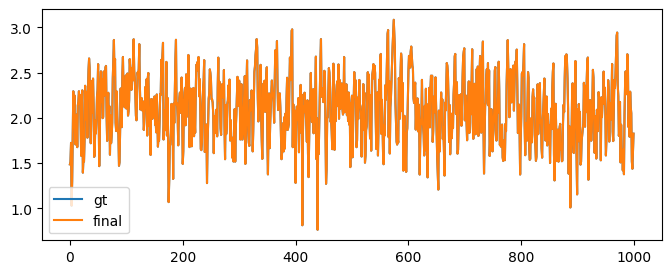

In [44]:
# plot 
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
gt_to_plot = jnp.log(gt_aff_cs_res[1:])
final_to_plot = log_final
fig, ax = plt.subplots(1,1, figsize=(800*px, 300*px))
t = np.arange(seq_len)
ax.plot(t, gt_to_plot, label='gt')
ax.plot(t, final_to_plot, label='final')
ax.legend()
plt.show()


### 3.2.2 Understanding the stability issue

In [5]:
log_a = jnp.log(a)
log_b = jnp.log(b)
a_star = jnp.cumsum(log_a)
c = jnp.exp(log_b - a_star)
d = 1 + jnp.cumsum(c)
log_final = a_star + jnp.log(d)
print(jnp.allclose(log_final, jnp.log(gt_aff_cs_res[1:]), atol=1e-6))

False


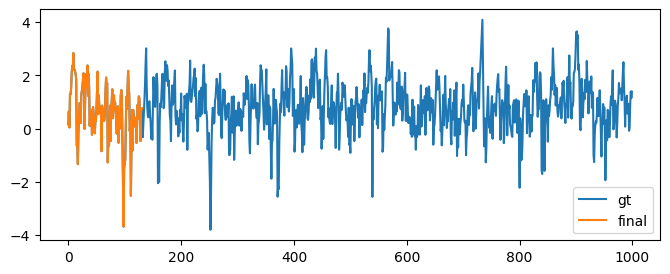

In [6]:
# plot 
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
gt_to_plot = jnp.log(gt_aff_cs_res[1:])
final_to_plot = log_final
fig, ax = plt.subplots(1,1, figsize=(800*px, 300*px))
t = np.arange(seq_len)
ax.plot(t, gt_to_plot, label='gt')
ax.plot(t, final_to_plot, label='final')
ax.legend()
plt.show()


We need to check that no cumulative sum is either `nan` or `inf`.

In [7]:
# check if a has a inf or nan
print('a')
print(jnp.any(jnp.isinf(a)))
print(jnp.any(jnp.isnan(a)))

# check if b has a inf or nan
print('b')
print(jnp.any(jnp.isinf(b)))
print(jnp.any(jnp.isnan(b)))

# check if c has a inf or nan
print('c')
print(jnp.any(jnp.isinf(c)))
print(jnp.any(jnp.isnan(c)))

False
False
False
False
True
False


We can see tha `c` has `inf` values because it computes the exponential of a cumulative sum.

In [8]:
print((log_b - a_star)[:10])
print(jnp.exp(log_b - a_star)[:10])

[-1.72  7.58  5.61  7.93  7.94  7.74  3.89  7.27  6.61  6.64]
[1.79e-01 1.96e+03 2.74e+02 2.79e+03 2.81e+03 2.31e+03 4.88e+01 1.44e+03
 7.43e+02 7.62e+02]


In [23]:
log_final[130:170]

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)

In [24]:
log_a = jnp.log(a)
log_b = jnp.log(b)
a_star = jnp.cumsum(log_a)
norm_c = jnp.max(log_b - a_star)
print(norm_c)
c = jnp.exp((log_b - a_star)-norm_c)*jnp.exp(norm_c)
d = 1 + jnp.cumsum(c)
log_final = a_star + jnp.log(d)
print(jnp.allclose(log_final, jnp.log(gt_aff_cs_res[1:]), atol=1e-6))

636.7073
False


In [25]:
jnp.exp(-norm_c)

Array(0., dtype=float32)

In [21]:
# check if a has a inf or nan
print(jnp.any(jnp.isinf(a)))
print(jnp.any(jnp.isnan(a)))

# check if b has a inf or nan
print(jnp.any(jnp.isinf(b)))
print(jnp.any(jnp.isnan(b)))

# check if c has a inf or nan
print(jnp.any(jnp.isinf(c)))
print(jnp.any(jnp.isnan(c)))

False
False
False
False
True
True


In [74]:
a = jnp.arange(11, 20) / 10
b = a 

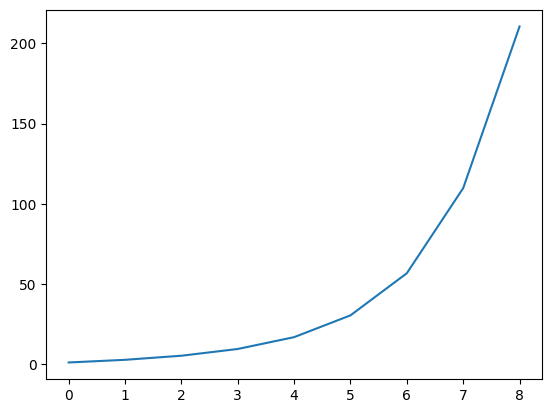

In [75]:
out = []
x_t = 0
for i in range(1, 10):
    x_t = a[i] * x_t + b[i]
    out.append(x_t)

plt.plot(out)

In [76]:
seq_len = 1000
key = jax.random.PRNGKey(0)
key, subkey_a, subkey_b = jax.random.split(key, 3)
# a = jax.random.normal(subkey_a, (seq_len,))
# uniform a from 0.1 to 1
a = jax.random.uniform(subkey_a, (seq_len,), minval=0.1, maxval=1)
 
#a = jnp.abs(a) # make sure it is positive, because we will use log
b = jax.random.normal(subkey_b, (seq_len,))
b_scaled = b + 4
#b = jnp.abs(b) # make sure it is positive, because we will use log
print(a[:5])

[0.24 0.55 0.38 0.15 0.34]


In [98]:
gt_aff_cs_res = []
x_t = 1
gt_aff_cs_res.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b[i]
    gt_aff_cs_res.append(x_t)
gt_aff_cs_res = jnp.array(gt_aff_cs_res)

gt_aff_cs_res_scaled = []
x_t = 1
gt_aff_cs_res_scaled.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b_scaled[i]
    gt_aff_cs_res_scaled.append(x_t)
gt_aff_cs_res_scaled = jnp.array(gt_aff_cs_res_scaled)

gt_aff_cs_res_biased_corrected = []
x_t = 1
gt_aff_cs_res_biased_corrected.append(x_t)
for i in range(seq_len):    
    x_t = a[i] * (x_t + 4) + b_scaled[i] - 4 * (a[i] + 1)
    gt_aff_cs_res_biased_corrected.append(x_t)



In [99]:
gt_aff_cs_res_biased = []
x_t = 1
gt_aff_cs_res_biased.append(x_t)
for i in range(seq_len):    
    x_t = a[i] * (x_t + 4) + b_scaled[i]
    gt_aff_cs_res_biased.append(x_t)

gt_aff_cs_res_biased_post = []
for i in range(seq_len):
    gt_aff_cs_res_biased_post.append(gt_aff_cs_res_biased[i] - 4 * (a[i] + 1))

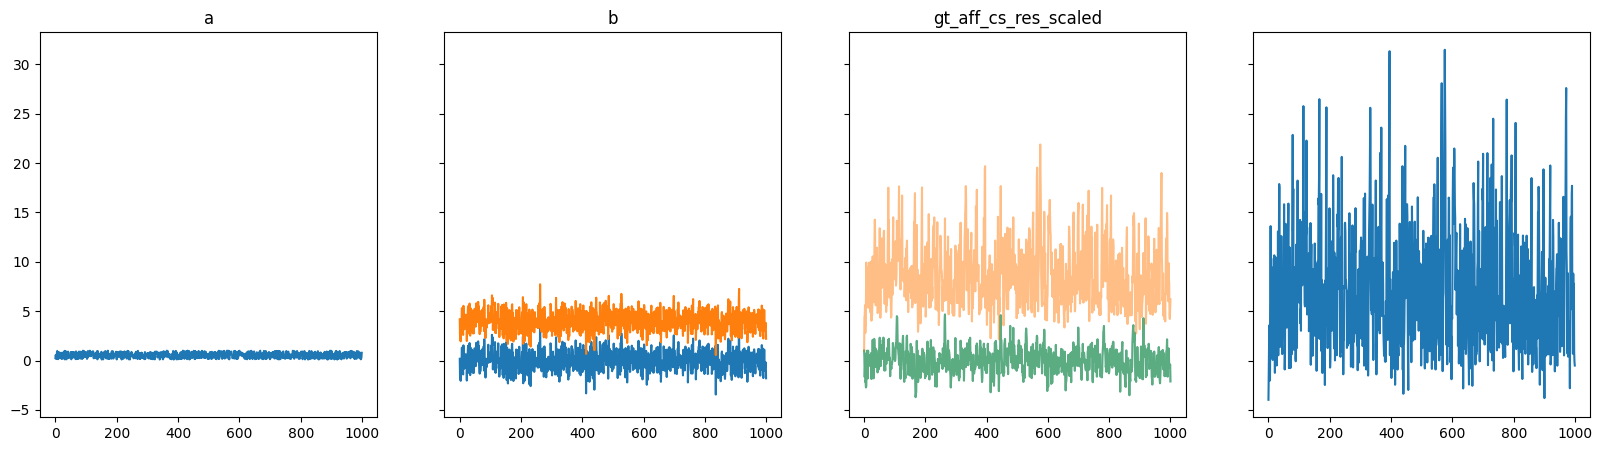

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
ax[0].plot(a)
ax[0].set_title('a')
ax[1].plot(b)
ax[1].set_title('b')
ax[1].plot(b_scaled)
ax[2].plot(gt_aff_cs_res, alpha=0.5)
ax[2].set_title('gt_aff_cs_res')
ax[2].plot(gt_aff_cs_res_scaled, alpha=0.5)
ax[2].plot(gt_aff_cs_res_biased_corrected, alpha=0.5)
ax[2].set_title('gt_aff_cs_res_scaled')
ax[3].plot(gt_aff_cs_res_biased_post)

plt.show()

In [ ]:
gt = []
x_t = 1
gt.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b[i]
    gt.append(x_t)
gt = jnp.array(gt)

offset = []
x_t = 1 + 4
offset.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + (b[i] + 4)
    offset.append(x_t)

correction = []


In [118]:
A = jnp.arange(16).reshape(4,4)
print(A[:,0])
print(A[1:,:2])
print(A[2:,:3])

[ 0  4  8 12]
[[ 4  5]
 [ 8  9]
 [12 13]]
[[ 8  9 10]
 [12 13 14]]


In [227]:
def corrections(a):
    seq_len = a.shape[0]
    A = jnp.zeros((seq_len, seq_len))
    A = A.at[:, 0].set(a[0])
    for i in range(1, seq_len):
        _A = A[i:, :i]
        # print(_A[:3])
        _B = jnp.ones((seq_len-i, i)) * a[i]
        # print(_B[:3])
        # print((_B * _A)[:3, :3])
        # print(_B.shape)
        # print(_A.shape)
        A = A.at[i:, :i].set(_B * _A)
        A = A.at[i:, i].set(a[i])
    return A.sum(axis=1), A

def cumprod(a):
    x_t = 1.
    res = []
    for _, a in enumerate(a):
        x_t *= a 
        res.append(x_t)
    return jnp.array(res)

def verify(a, A, row_id):
    _a = a[:row_id+1]
    # reverse _a 
    _a = _a[::-1]
    print(_a)
    _a = cumprod(_a)
    # reverse _a
    _a = _a[::-1]
    print(_a)
    print(A[row_id])
    


In [228]:
z = jnp.arange(1,5)
print(z)
print(cumprod(z))

[1 2 3 4]
[ 1.  2.  6. 24.]


In [229]:
seq_len = 5
a = 1 / jnp.arange(2,2+seq_len)
#a = jnp.ones(seq_len)*0.5
print(a)
print(a.shape)
A = jnp.zeros((seq_len, seq_len))
A = A.at[:, 0].set(a[0])
print(A[:,:1])

[0.5  0.33 0.25 0.2  0.17]
(5,)
[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]


In [230]:
for i in range(1, seq_len):
    print(i, a[i])
    _A = A[i:, :i]
    # print(_A[:3])
    _B = jnp.ones((seq_len-i, i)) * a[i]
    # print(_B[:3])
    # print((_B * _A)[:3, :3])
    # print(_B.shape)
    # print(_A.shape)
    A = A.at[i:, :i].set(_B * _A)
    A = A.at[i:, i].set(a[i])
    # print(A[:3, :3])


1 0.33333334
2 0.25
3 0.2
4 0.16666667


In [231]:
# print a without the scientific notation
jnp.set_printoptions(suppress=True)
print(A)

[[0.5  0.   0.   0.   0.  ]
 [0.17 0.33 0.   0.   0.  ]
 [0.04 0.08 0.25 0.   0.  ]
 [0.01 0.02 0.05 0.2  0.  ]
 [0.   0.   0.01 0.03 0.17]]


In [232]:
verify(a, A, 3)

[0.2  0.25 0.33 0.5 ]
[0.01 0.02 0.05 0.2 ]
[0.01 0.02 0.05 0.2  0.  ]


In [316]:


def fn_gt(a, b, x0):
    x_t = x0
    res = []
    res.append(x_t)
    for i in range(seq_len):
        x_t = a[i] * x_t + b[i]
        res.append(x_t)
    return jnp.array(res)



def fn_bias(a, b, bias):
    x_t = 1 + bias
    res = []
    res.append(x_t)
    for i in range(seq_len):
        x_t = a[i] * x_t + (b[i] + bias)
        res.append(x_t)
    return jnp.array(res)


def ass_scan(a,b,x0):
    log_a = jnp.log(a)
    a_star = jnp.cumsum(log_a)

    log_b = jnp.log(b)
    c = log_b - a_star 
    c_star = jnp.zeros((c.shape[0]+ 1, ))
    c_star = c_star.at[1:].set(c)
    c_star = c_star.at[0].set(jnp.log(x0))
    d = jax.lax.cumlogsumexp(c_star)
    d = d[1:] # tailing d
    log_final = a_star + d
    return jnp.exp(log_final)

def fn_bias_ass_scan(a,b,bias, x0):
    biased = ass_scan(a, b+bias, x0+bias)
    _b = jnp.zeros((biased.shape[0]+1,))
    _b = _b.at[1:].set(biased)
    return fn_correction(_b, a, bias)

def fn_bias_loop(a,b,bias):
    biased = fn_bias(a, b, bias)
    return fn_correction(biased, a, bias)
    


def fn_correction(biased, a, bias):
    _corr, _ = corrections(a)
    return biased[1:] - bias * (_corr + 1)



In [ ]:
seq_len = 10
a = 1 / jnp.arange(2,2+seq_len)
b = jnp.ones(seq_len) * 0.5

gt = fn_gt(a, b, 1)
print(gt.shape)

bias = 4
biased = fn_bias(a, b, bias)
print(biased.shape)

corrected = fn_correction(biased, a, bias)



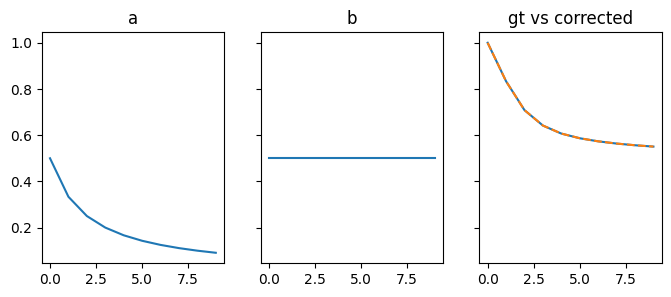

In [246]:
from matplotlib import pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, ax = plt.subplots(1, 3, figsize=(800*px, 300*px), sharey=True)
ax[0].plot(a)
ax[0].set_title('a')
ax[1].plot(b)
ax[1].set_title('b')
ax[2].plot(gt[1:])
# ax[2].plot(biased)
ax[2].plot(corrected, ls='--')
ax[2].set_title('gt vs corrected')
plt.show()

In [306]:
key = jax.random.PRNGKey(0)
key, subkey_a, subkey_b = jax.random.split(key, 3)
seq_len = 200
a = jax.random.uniform(subkey_a, (seq_len,), minval=0.1, maxval=1)
b = jax.random.normal(subkey_b, (seq_len,))
bias = 4

gt = fn_gt(a, b,
biased = fn_bias(a, b, bias)
corrected = fn_correction(biased, a, bias)


TypeError: fn_gt() missing 1 required positional argument: 'x0'

In [307]:
biased = fn_bias(a, b, bias)
corrected = fn_correction(biased, a, bias)

In [308]:
biased_ass_scan = fn_bias_ass_scan(a,b,bias)

biased_loop = fn_bias_loop(a,b,bias)


TypeError: fn_bias_ass_scan() missing 1 required positional argument: 'x0'

In [ ]:
%timeit -n 10 -r 7 fn_bias_ass_scan(a,b,bias)

184 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [259]:
%timeit -n 10 -r 7 fn_bias_loop(a,b,bias)


212 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


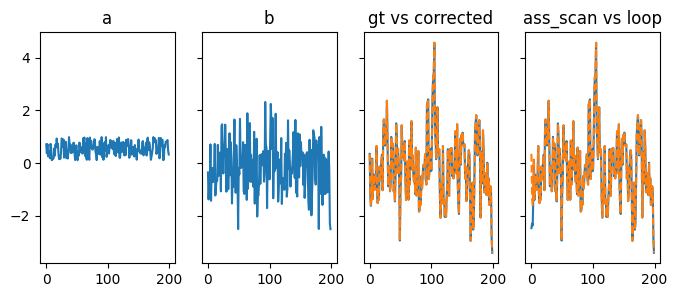

In [260]:
from matplotlib import pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, ax = plt.subplots(1, 4, figsize=(800*px, 300*px), sharey=True)
ax[0].plot(a)
ax[0].set_title('a')
ax[1].plot(b)
ax[1].set_title('b')
ax[2].plot(gt[1:])
# ax[2].plot(biased)
ax[2].plot(corrected, ls='--')
ax[2].set_title('gt vs corrected')
ax[3].plot(biased_ass_scan)
ax[3].plot(biased_loop, ls='--')
ax[3].set_title('ass_scan vs loop')

plt.show()

In [372]:
key = jax.random.PRNGKey(0)
key, subkey_a, subkey_b = jax.random.split(key, 3)
seq_len = 2000
a = jax.random.uniform(subkey_a, (seq_len,), minval=0.1, maxval=1)
b = jax.random.normal(subkey_b, (seq_len,))

In [373]:
x0 = 0.5
B = 4
gt = fn_gt(a,b,x0)
x_as = ass_scan(a,b,1)
x_b = ass_scan(a,b+B,x0+B)
corr = ass_scan(a,jnp.ones_like(b),1)
x_corr = x_b - B*corr

In [374]:
print(f'{a.shape=}')
print(f'{gt.shape=}')
print(f'{x_as.shape=}')
print(f'{x_b.shape=}')
print(f'{corr.shape=}')
print(f'{x_corr.shape=}')

a.shape=(2000,)
gt.shape=(2001,)
x_as.shape=(2000,)
x_b.shape=(2000,)
corr.shape=(2000,)
x_corr.shape=(2000,)


In [375]:
def ass_scan_b(a,b,x0,B):
    log_a = jnp.log(a)
    a_star = jnp.cumsum(log_a)

    log_b = jnp.log(b + B)
    c = log_b - a_star 
    c_star = jnp.zeros((c.shape[0]+ 1, ))
    c_star = c_star.at[1:].set(c)
    c_star = c_star.at[0].set(jnp.log(x0))
    d = jax.lax.cumlogsumexp(c_star)
    log_final = a_star + d[1:]

    # correction 
    c_star = jnp.zeros((a.shape[0]+ 1, ))
    c_star = c_star.at[1:].set( - a_star)
    c_star = c_star.at[0].set(0)
    d = jax.lax.cumlogsumexp(c_star)
    log_corr = a_star + d[1:]
    return jnp.exp(log_final) - B * jnp.exp(log_corr)

In [376]:
x_as_corr = ass_scan_b(a,b,x0,B)

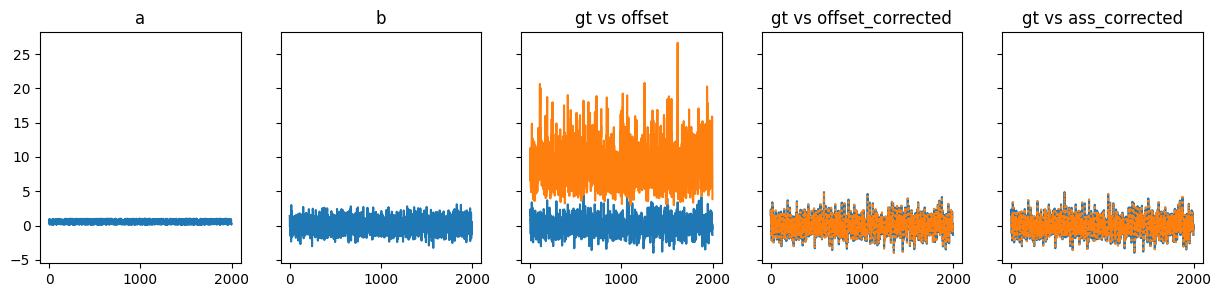

In [392]:
from matplotlib import pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

fig, ax = plt.subplots(1, 5, figsize=(1500*px, 300*px), sharey=True)
ax[0].plot(a)
ax[0].set_title('a')
ax[1].plot(b)
ax[1].set_title('b')
ax[2].plot(gt[1:])
ax[2].plot(x_b)
ax[2].set_title('gt vs offset')
ax[3].plot(gt[1:])
ax[3].plot(x_corr, ls=':')
ax[3].set_title('gt vs offset_corrected')
ax[4].plot(gt[1:])
ax[4].plot(x_as_corr, ls=':')
ax[4].set_title('gt vs ass_corrected')

plt.show()

In [378]:
def ass_scan_corr(a,b,x0,B):
    x_b = ass_scan(a,b+B,x0+B)
    corr = ass_scan(a,jnp.ones_like(b),1)
    return x_b - B*corr

In [379]:
%timeit -n 10 -r 7 ass_scan_corr(a,b,x0,B)

2.37 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [380]:
%timeit -n 10 -r 7 ass_scan_b(a,b,x0,B)

The slowest run took 4.06 times longer than the fastest. This could mean that an intermediate result is being cached.
2.24 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [381]:
j_ass_scan_b = jax.jit(ass_scan_b)
j_ass_scan_corr = jax.jit(ass_scan_corr)

In [382]:
# warmup
_ = j_ass_scan_b(a,b,x0,B)
_ = j_ass_scan_corr(a,b,x0,B)

In [383]:
%timeit -n 1000 -r 7 jax.block_until_ready(j_ass_scan_corr(a,b,x0,B))

277 μs ± 14.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [384]:
%timeit -n 1000 -r 7 jax.block_until_ready(j_ass_scan_b(a,b,x0,B))

277 μs ± 14.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
